## Package Imports

In [1]:
import torch 
from torch import optim
from torch.optim import Optimizer
from torch.nn import Linear, CrossEntropyLoss
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

from torchvision import transforms
from torchvision.models import ResNet
from torchvision.models import resnet34
from torchvision.datasets import ImageFolder

from numpy import log10, floor, power

from PIL import Image

## Load the images data

In [2]:
def pad_to_square(stock):
    x, y = stock.size
    d = max(x, y)
    padded = Image.new(mode='RGB', size=(d, d), color=(255, 255, 255))
    padded.paste(stock, ((d - x) // 2, (d - y) // 2))
    return padded

image_refactor = transforms.Compose([
    transforms.Lambda(pad_to_square),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

real_test_set = ImageFolder(root='./data/real_test', transform=image_refactor)
real_train_set = ImageFolder(root='./data/real_train', transform=image_refactor)
sketch_test_set = ImageFolder(root='./data/sketch_test', transform=image_refactor)
sketch_train_set = ImageFolder(root='./data/sketch_train', transform=image_refactor)

real_test_loader = DataLoader(real_test_set, batch_size=64, shuffle=True)
real_train_loader = DataLoader(real_train_set, batch_size=64, shuffle=True)
sketch_test_loader = DataLoader(sketch_test_set, batch_size=64, shuffle=True)
sketch_train_loader = DataLoader(sketch_train_set, batch_size=64, shuffle=True)


## Define a function for training and validating

In [3]:
def train_and_validate(
    model: ResNet, 
    src_loader: DataLoader, 
    tar_loader: DataLoader, 
    val_loader: DataLoader, 
    optimizer: Optimizer,
    loss_fn = CrossEntropyLoss(),
    closs_weight: float = 1.0,
    epochs: int = 1,
    early_stop_margin: float = -1,
    checkpoint_dir_prefix: str = None,
):
    model.train()
    src_losses = []
    src_accs = []
    tar_losses = []
    tar_accs = []
    val_losses = []
    val_accs = []
    coral_losses = []
    combined_losses = []
    # loss_deltas = []
    epochs_digits = int(floor(log10(epochs)) + 1)

    for e in range(epochs):
        r_loss = 0.0
        src_losses.append(0.0)
        tar_losses.append(0.0)
        coral_losses.append(0.0)
        combined_losses.append(0.0)
        s_matches = 0
        t_matches = 0
        sy_dim = 0
        ty_dim = 0

        for i, ((sX, sy), (tX, ty)) in enumerate(zip(src_loader, tar_loader)):
            if sX.size(0) == tX.size(0): # use CORAL loss if feature dimensions match
                optimizer.zero_grad()

                # features extration in source domain
                sf = model.conv1(sX)
                sf = model.bn1(sf)
                sf = model.relu(sf)
                sf = model.maxpool(sf)
                sf = model.layer1(sf)
                sf = model.layer2(sf)
                sf = model.layer3(sf)
                sf = model.layer4(sf)
                sf = model.avgpool(sf)
                sf = sf.view(sf.size(0), -1)

                # features extration in target domain
                tf = model.conv1(tX)
                tf = model.bn1(tf)
                tf = model.relu(tf)
                tf = model.maxpool(tf)
                tf = model.layer1(tf)
                tf = model.layer2(tf)
                tf = model.layer3(tf)
                tf = model.layer4(tf)
                tf = model.avgpool(tf)
                tf = tf.view(tf.size(0), -1)

                d = sf.size(0)

                # compute the coral loss:
                #     coral_loss = Frobenius norm (|Cs-Ct|) * (4d^2)
                coral_loss = torch.float_power(
                    torch.norm(
                        torch.sub(torch.cov(sf), torch.cov(tf)), 
                        p='fro'
                    ), 
                    2
                ) / (4 * power(d, 2))

                # final output of source domain
                _sy_probs = model.fc(sf)

                # base loss
                s_loss = loss_fn(_sy_probs, sy)

                # combined loss
                combined_loss = s_loss + closs_weight * coral_loss

                with torch.no_grad():
                    _ty_probs = model.fc(tf)
                    r_loss += combined_loss.item()
                    src_losses[-1] += s_loss.item()
                    coral_losses[-1] += coral_loss.item()
                    combined_losses[-1] += combined_loss.item()
                    tar_losses[-1] += loss_fn(_ty_probs, ty).item()

                    _sy = _sy_probs.softmax(dim=1).argmax(dim=1)
                    s_matches += (sy == _sy).sum().item()
                    sy_dim += sy.size(0)
                    _ty = _ty_probs.softmax(dim=1).argmax(dim=1)
                    t_matches += (ty == _ty).sum().item()
                    ty_dim += ty.size(0)

                # backward pass using combined loss
                combined_loss.backward()
                optimizer.step()
            else: # use base loss in case of mismatched feature dimensions
                optimizer.zero_grad()
                _sy_probs = model.forward(sX)
                s_loss = loss_fn(_sy_probs, sy)

                with torch.no_grad():
                    r_loss += s_loss.item()
                    _ty_probs = model.forward(tX)
                    src_losses[-1] += s_loss.item()
                    combined_losses[-1] += s_loss.item()
                    tar_losses[-1] += loss_fn(_ty_probs, ty).item()
                    
                    _sy = _sy_probs.softmax(dim=1).argmax(dim=1)
                    s_matches += (sy == _sy).sum().item()
                    sy_dim += sy.size(0)
                    _ty = _ty_probs.softmax(dim=1).argmax(dim=1)
                    t_matches += (ty == _ty).sum().item()
                    ty_dim += ty.size(0)

                s_loss.backward()
                optimizer.step()

        if checkpoint_dir_prefix is not None:
            torch.save(model.state_dict(), "{}/{:0{}d}.pth".format(checkpoint_dir_prefix, e, epochs_digits))

        src_accs.append(s_matches / sy_dim)
        tar_accs.append(t_matches / ty_dim)

        # validation
        with torch.no_grad():
            val_losses.append(0.0)
            matches = 0
            y_dim = 0

            for i, (X, y) in enumerate(val_loader):
                _y_probs = model.forward(X)
                val_losses[-1] += loss_fn(_y_probs, y).item()
                _y = _y_probs.softmax(dim=1).argmax(dim=1)
                matches += (y == _y).sum().item()
                y_dim += y.size(0)

            val_accs.append(matches / y_dim)

        # early stopping alternative (on loss delta percentile)
        # loss_delta = train_losses[-2] - train_losses[-1] if len(train_losses) > 1 else 0.0
        # if (len(loss_deltas) > 0) and (loss_delta < (loss_deltas[-1] * early_stop_margin)):

        # early stopping on loss delta
        # will calculate the output for one extra iteration to document the performance of the final training cycle
        if (len(combined_losses) > 1) and ((combined_losses[-2] - combined_losses[-1]) < early_stop_margin):

            with torch.no_grad():
                src_losses.append(0.0)
                tar_losses.append(0.0)
                coral_losses.append(0.0)
                combined_losses.append(0.0)
                s_matches = 0
                t_matches = 0
                sy_dim = 0
                ty_dim = 0

                for i, ((sX, sy), (tX, ty)) in enumerate(zip(src_loader, tar_loader)):
                    if sX.size(0) == tX.size(0):
                        # features extration in source domain
                        sf = model.conv1(sX)
                        sf = model.bn1(sf)
                        sf = model.relu(sf)
                        sf = model.maxpool(sf)
                        sf = model.layer1(sf)
                        sf = model.layer2(sf)
                        sf = model.layer3(sf)
                        sf = model.layer4(sf)
                        sf = model.avgpool(sf)
                        sf = sf.view(sf.size(0), -1)

                        # features extration in target domain
                        tf = model.conv1(tX)
                        tf = model.bn1(tf)
                        tf = model.relu(tf)
                        tf = model.maxpool(tf)
                        tf = model.layer1(tf)
                        tf = model.layer2(tf)
                        tf = model.layer3(tf)
                        tf = model.layer4(tf)
                        tf = model.avgpool(tf)
                        tf = tf.view(tf.size(0), -1)

                        d = sf.size(0)

                        # coral loss:
                        coral_loss = torch.float_power(
                            torch.norm(
                                torch.sub(torch.cov(sf), torch.cov(tf)), 
                                p='fro'
                            ), 
                            2
                        ) / (4 * power(d, 2))

                        _sy_probs = model.fc(sf)

                        # source loss
                        s_loss = loss_fn(_sy_probs, sy)

                        # combined loss
                        combined_loss = s_loss + closs_weight * coral_loss

                        _ty_probs = model.fc(tf)
                        src_losses[-1] += s_loss.item()
                        coral_losses[-1] += coral_loss.item()
                        combined_losses[-1] += combined_loss.item()
                        tar_losses[-1] += loss_fn(_ty_probs, ty).item()

                        _sy = _sy_probs.softmax(dim=1).argmax(dim=1)
                        s_matches += (sy == _sy).sum().item()
                        sy_dim += sy.size(0)
                        _ty = _ty_probs.softmax(dim=1).argmax(dim=1)
                        t_matches += (ty == _ty).sum().item()
                        ty_dim += ty.size(0)

                    else:
                        _sy_probs = model.forward(sX)
                        s_loss = loss_fn(_sy_probs, sy)

                        _ty_probs = model.forward(tX)
                        src_losses[-1] += s_loss.item()
                        combined_losses[-1] += s_loss.item()
                        tar_losses[-1] += loss_fn(_ty_probs, ty).item()
                        
                        _sy = _sy_probs.softmax(dim=1).argmax(dim=1)
                        s_matches += (sy == _sy).sum().item()
                        sy_dim += sy.size(0)
                        _ty = _ty_probs.softmax(dim=1).argmax(dim=1)
                        t_matches += (ty == _ty).sum().item()
                        ty_dim += ty.size(0)

                src_accs.append(s_matches / sy_dim)
                tar_accs.append(t_matches / ty_dim)

            return {
                "model": model,
                "src-losses": src_losses[1:],
                "src-accs": src_accs[1:],
                "tar-losses": tar_losses[1:],
                "tar-accs": tar_accs[1:],
                "val-losses": val_losses,
                "val-accs": val_accs,
                "coral-losses": coral_losses[1:],
                "combined-losses": combined_losses[1:],
            }

        # loss_deltas.append(loss_delta)

    # calculating the output for one extra iteration to document the performance of the final training cycle
    with torch.no_grad():
        src_losses.append(0.0)
        tar_losses.append(0.0)
        coral_losses.append(0.0)
        combined_losses.append(0.0)
        s_matches = 0
        t_matches = 0
        sy_dim = 0
        ty_dim = 0

        for i, ((sX, sy), (tX, ty)) in enumerate(zip(src_loader, tar_loader)):
            if sX.size(0) == tX.size(0):
                # features extration in source domain
                sf = model.conv1(sX)
                sf = model.bn1(sf)
                sf = model.relu(sf)
                sf = model.maxpool(sf)
                sf = model.layer1(sf)
                sf = model.layer2(sf)
                sf = model.layer3(sf)
                sf = model.layer4(sf)
                sf = model.avgpool(sf)
                sf = sf.view(sf.size(0), -1)

                # features extration in target domain
                tf = model.conv1(tX)
                tf = model.bn1(tf)
                tf = model.relu(tf)
                tf = model.maxpool(tf)
                tf = model.layer1(tf)
                tf = model.layer2(tf)
                tf = model.layer3(tf)
                tf = model.layer4(tf)
                tf = model.avgpool(tf)
                tf = tf.view(tf.size(0), -1)

                d = sf.size(0)

                # coral loss:
                coral_loss = torch.float_power(
                    torch.norm(
                        torch.sub(torch.cov(sf), torch.cov(tf)), 
                        p='fro'
                    ), 
                    2
                ) / (4 * power(d, 2))

                _sy_probs = model.fc(sf)

                # source loss
                s_loss = loss_fn(_sy_probs, sy)

                # combined loss
                combined_loss = s_loss + closs_weight * coral_loss

                _ty_probs = model.fc(tf)
                src_losses[-1] += s_loss.item()
                coral_losses[-1] += coral_loss.item()
                combined_losses[-1] += combined_loss.item()
                tar_losses[-1] += loss_fn(_ty_probs, ty).item()

                _sy = _sy_probs.softmax(dim=1).argmax(dim=1)
                s_matches += (sy == _sy).sum().item()
                sy_dim += sy.size(0)
                _ty = _ty_probs.softmax(dim=1).argmax(dim=1)
                t_matches += (ty == _ty).sum().item()
                ty_dim += ty.size(0)

            else:
                _sy_probs = model.forward(sX)
                s_loss = loss_fn(_sy_probs, sy)

                _ty_probs = model.forward(tX)
                src_losses[-1] += s_loss.item()
                combined_losses[-1] += s_loss.item()
                tar_losses[-1] += loss_fn(_ty_probs, ty).item()
                
                _sy = _sy_probs.softmax(dim=1).argmax(dim=1)
                s_matches += (sy == _sy).sum().item()
                sy_dim += sy.size(0)
                _ty = _ty_probs.softmax(dim=1).argmax(dim=1)
                t_matches += (ty == _ty).sum().item()
                ty_dim += ty.size(0)

        src_accs.append(s_matches / sy_dim)
        tar_accs.append(t_matches / ty_dim)
    
    return {
        "model": model,
        "src-losses": src_losses[1:],
        "src-accs": src_accs[1:],
        "tar-losses": tar_losses[1:],
        "tar-accs": tar_accs[1:],
        "val-losses": val_losses,
        "val-accs": val_accs,
        "coral-losses": coral_losses[1:],
        "combined-losses": combined_losses[1:],
    }


## Train the domain adaptation model on real domain with reference of sketch domain for sketch domain

In [4]:
r34_real = resnet34(pretrained=True)
r34_real.fc = Linear(in_features=r34_real.fc.in_features, out_features=10)

# model, train_losses, train_accuracies, test_losses, test_accuracies
r34_real_metrics = \
    train_and_validate(
        r34_real, 
        real_train_loader, 
        sketch_train_loader, 
        sketch_test_loader, 
        optimizer=optim.SGD(r34_real.parameters(), lr=0.005, momentum=0.9), 
        closs_weight=10.0,
        epochs=100, 
        early_stop_margin=0.1,
        checkpoint_dir_prefix="./checkpoints/real-r34-DA"
    )

c:\Program Files\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Program Files\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Model performance graphs

<Figure size 432x288 with 0 Axes>

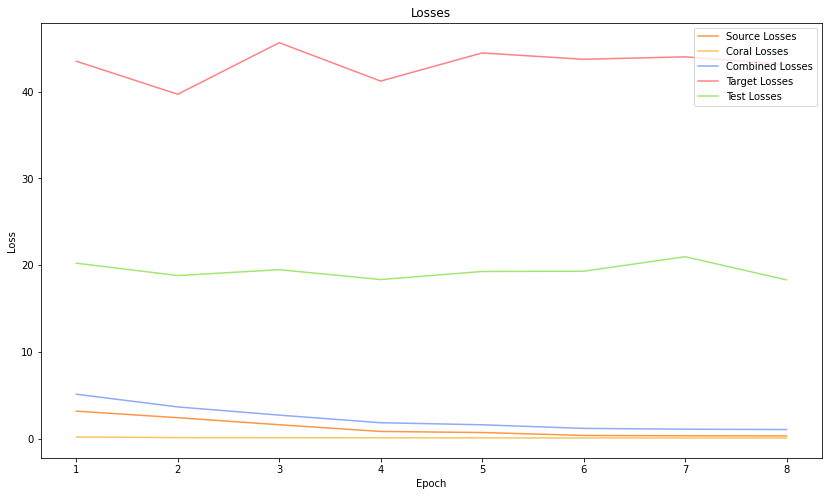

In [5]:
plt.clf()

epochs = range(1, len(r34_real_metrics["src-losses"]) + 1)

fig, canvas = plt.subplots(1, 1, figsize=(14, 8))

canvas.plot(epochs, r34_real_metrics["src-losses"], color=(255/255, 150/255, 69/255), label="Source Losses")
canvas.plot(epochs, r34_real_metrics["coral-losses"], color=(249/255, 197/255, 95/255), label="Coral Losses")
canvas.plot(epochs, r34_real_metrics["combined-losses"], color=(142/255, 170/255, 251/255), label="Combined Losses")
canvas.plot(epochs, r34_real_metrics["tar-losses"], color=(255/255, 129/255, 131/255), label="Target Losses")
canvas.plot(epochs, r34_real_metrics["val-losses"], color=(162/255, 231/255, 115/255), label="Test Losses")
canvas.set_title("Losses")
canvas.set_xlabel("Epoch")
canvas.set_ylabel("Loss")
canvas.set_xticks(epochs)
canvas.legend(loc="upper right")

plt.savefig("./fig/real-r34-DA-losses.jpg")

<Figure size 432x288 with 0 Axes>

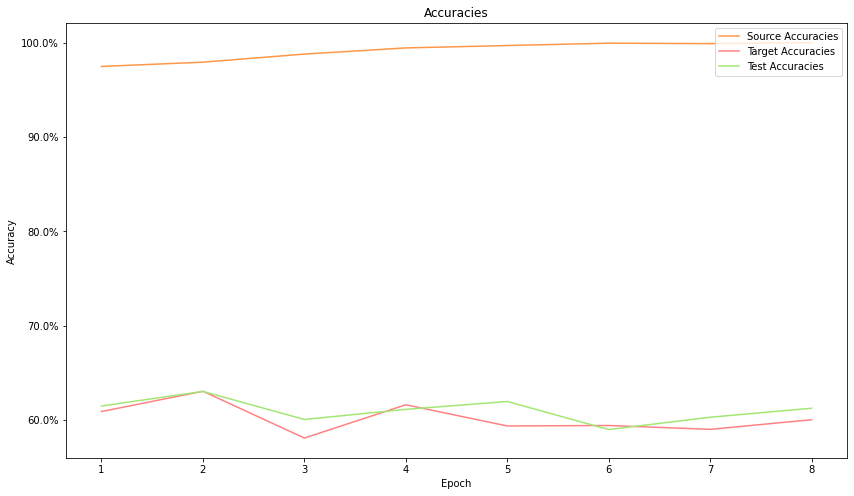

In [6]:
plt.clf()

fig, canvas = plt.subplots(1, 1, figsize=(14, 8))

canvas.plot(epochs, r34_real_metrics["src-accs"], color=(255/255, 150/255, 69/255), label="Source Accuracies")
canvas.plot(epochs, r34_real_metrics["tar-accs"], color=(255/255, 129/255, 131/255), label="Target Accuracies")
canvas.plot(epochs, r34_real_metrics["val-accs"], color=(162/255, 231/255, 115/255), label="Test Accuracies")
canvas.set_title("Accuracies")
canvas.set_xlabel("Epoch")
canvas.set_ylabel("Accuracy")
canvas.legend(loc="upper right")

canvas.set_xticks(epochs)
canvas.yaxis.set_major_formatter(PercentFormatter(1.0))

plt.savefig("./fig/real-r34-DA-accs.jpg")


In [10]:
r34_real_metrics["src-losses"]

[3.1740754451602697,
 2.418297840282321,
 1.6051496751606464,
 0.8306093094870448,
 0.708992650732398,
 0.3726369347423315,
 0.3334791879169643,
 0.31387414783239365]

In [14]:
r34_real_metrics["src-accs"]

[0.9747983870967742,
 0.9793346774193549,
 0.9879032258064516,
 0.9944556451612904,
 0.9969758064516129,
 0.9994959677419355,
 0.998991935483871,
 1.0]

In [9]:
r34_real_metrics["tar-losses"]

[43.50679159164429,
 39.69615924358368,
 45.6407744884491,
 41.21449691057205,
 44.45724868774414,
 43.72683399915695,
 44.00945317745209,
 43.11542224884033]

In [13]:
r34_real_metrics["tar-accs"]

[0.6088957055214724,
 0.6303680981595092,
 0.5807770961145194,
 0.6160531697341514,
 0.593558282208589,
 0.5940695296523517,
 0.5899795501022495,
 0.6002044989775052]

In [12]:
r34_real_metrics["val-losses"]

[20.226078391075134,
 18.799829840660095,
 19.47462522983551,
 18.341548204421997,
 19.271141409873962,
 19.297446608543396,
 20.97295093536377,
 18.301976323127747]

In [11]:
r34_real_metrics["val-accs"]

[0.6147443519619501,
 0.6302021403091558,
 0.6004756242568371,
 0.6111771700356718,
 0.619500594530321,
 0.5897740784780023,
 0.6028537455410226,
 0.6123662306777645]

In [7]:
r34_real_metrics["coral-losses"]

[0.1949712832809073,
 0.12400864711863285,
 0.11100883204272062,
 0.10062139783642096,
 0.08919049739154407,
 0.08119776276525882,
 0.07601985600193492,
 0.07375496185814051]

In [8]:
r34_real_metrics["combined-losses"]

[5.123788277969343,
 3.6583843114686485,
 2.7152379955878523,
 1.8368232878512551,
 1.600897624647839,
 1.1846145623949194,
 1.0936777479363133,
 1.0514237664137984]